## 2D quadrotor

The quadrotor is depicted in the following figure <img src='quadrotor.png' width="300">
The quadrotor model is written as
$$\begin{align} 
\dot{x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $x$ is the horizontal and $y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $z = [x, v_x, y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines useful constants (mass, length, gravity, etc) and functions to simulate and animate the quadrotor as shown below.

In [1]:
# %matplotlib notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import quadrotor

import jax
import jax.numpy as jnp

from typing import Callable, NamedTuple

import importlib

In [2]:
# we can get its mass, half length (r), gravity constant
print(f'm is {quadrotor.MASS}')
print(f'r is {quadrotor.LENGTH}')
print(f'I is {quadrotor.INERTIA}')
print(f'g is {quadrotor.GRAVITY}')

# we can also get the integration step used in the simulation
print(f'dt is {quadrotor.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {quadrotor.NUMBER_STATES} and number of controls {quadrotor.NUMBER_CONTROLS}')
print('the states are indexed as follows: x, vx, y, vy, theta, omega')

m is 0.6
r is 0.2
I is 0.15
g is 9.81
dt is 0.01
number of states 6 and number of controls 2
the states are indexed as follows: x, vx, y, vy, theta, omega


In [3]:
# Notation from https://github.com/StanfordASL/AA203-Notes/blob/master/notes.pdf;
# notation from https://asl.stanford.edu/aa203/pdfs/lecture/lectures_9_and_10.pdf in comments.

class LinearDynamics(NamedTuple):
    """dynamics system (3.24) without d"""
    f_x: jnp.array  # A
    f_u: jnp.array  # B

    def __call__(self, x, u, k=None):
        f_x, f_u = self
        
        if k is None:
            return f_x @ x + f_u @ u
        else:    
            return self[k](x, u)

    def __getitem__(self, key):
        return jax.tree.map(lambda x: x[key], self)

class AffinePolicy(NamedTuple):
    """policy (3.28)"""
    l: jnp.array  # l
    l_x: jnp.array  # L

    def __call__(self, x, k=None):
        l, l_x = self
        return l + l_x @ x if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree.map(lambda x: x[key], self)

class QuadraticCost(NamedTuple):
    """stage-wise cost (3.22)"""
    c: jnp.array      # c
    c_x: jnp.array    # q
    c_u: jnp.array    # r
    c_xx: jnp.array   # Q
    c_uu: jnp.array   # R
    c_ux: jnp.array   # H.T

    @classmethod
    def from_pure_quadratic(cls, c_xx, c_uu, c_ux):
        return cls(
            jnp.zeros((c_xx.shape[:-2])),   # c (scalar)
            jnp.zeros(c_xx.shape[:-1]),     # q (vector)
            jnp.zeros(c_uu.shape[:-1]),     # r (vector)
            c_xx,                           # Q  
            c_uu,                           # R  
            c_ux,                           # H.T  
        )

    def __call__(self, x, u, k=None):
        c, c_x, c_u, c_xx, c_uu, c_ux = self
        return c + c_x @ x + c_u @ u + x @ c_xx @ x / 2 + u @ c_uu @ u / 2 + u @ c_ux @ x if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree.map(lambda x: x[key], self)

class QuadraticStateCost(NamedTuple):
    """terminal cost (3.23) hoặc 5."""
    v: jnp.array      # p (scalar)
    v_x: jnp.array    # p (vector)
    v_xx: jnp.array   # P

    @classmethod
    def from_pure_quadratic(cls, v_xx):
        return cls(
            jnp.zeros(v_xx.shape[:-2]), 
            jnp.zeros(v_xx.shape[:-1]),
            v_xx,
        )

    def __call__(self, x, k=None):
        v, v_x, v_xx = self
        return v + v_x @ x + x @ v_xx @ x / 2 if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree.map(lambda x: x[key], self)


def rollout_state_feedback_policy(dynamics, policy, x0, step_range, x_nom=None, u_nom=None):
    """ trả ra state k, control u* """
    def scan_fn(x, k):  # k follows step_range
        if x_nom is None:
            u = policy(x, k)
        else:
            u = u_nom[k] + policy(x - x_nom[k], k)
        x1 = dynamics(x, u, k)
        return (x1, (x1, u))

    xs, us = jax.lax.scan(scan_fn, x0, step_range)[1] # [1] : (x1, u)
    return jnp.concatenate([x0[None], xs]), us

In [4]:
def riccati_step(
    current_step_dynamics: LinearDynamics,
    current_step_cost: QuadraticCost,
    next_state_value: QuadraticStateCost,
):
    """
    - `current_step_dynamics`: dynamics system (3.24)
    - `current_step_cost`: stage-wise cost (3.22)
    - `next_state_value`: terminal cost (3.23)
    """
    f_x, f_u = current_step_dynamics                  # A, B
    c, c_x, c_u, c_xx, c_uu, c_ux = current_step_cost # c, q, r, Q, R, H
    v, v_x, v_xx = next_state_value                   # q, q, Q

    #
    q = c + v

    # S(x,k); S(u,k)
    q_x = c_x + f_x.T @ v_x             
    q_u = c_u + f_u.T @ v_x             # 3.29

    # S(xx,k); S(uu,k); S(ux,k)
    q_xx = c_xx + f_x.T @ v_xx @ f_x
    q_uu = c_uu + f_u.T @ v_xx @ f_u    # S(uu,k) (3.30)
    q_ux = c_ux + f_u.T @ v_xx @ f_x    # S(ux,k) (3.31)

    # lk; Lk
    l = -jnp.linalg.solve(q_uu, q_u)    # 3.33
    l_x = -jnp.linalg.solve(q_uu, q_ux) # 3.32

    current_state_value = QuadraticStateCost(
        q - l.T @ q_uu @ l / 2,       # 3.36
        q_x - l_x.T @ q_uu @ l,       # 3.35
        q_xx - l_x.T @ q_uu @ l_x,    # 3.34
    )

    current_step_optimal_policy = AffinePolicy(l, l_x) # 3.28
    return current_state_value, current_step_optimal_policy


@jax.jit
def linear_quadratic_regulator(Qs, Rs, Hs, As, Bs):
    final_state_value = QuadraticStateCost.from_pure_quadratic(Qs[-1]) # c, q, r, Q, R, H
    dynamics = LinearDynamics(As, Bs) # 0 => N; jax.tree.map [k]
    cost = QuadraticCost.from_pure_quadratic(Qs[:-1], Rs, Hs)

    def scan_fn(next_state_value, current_step_dynamics_cost):
        current_step_dynamics, current_step_cost = current_step_dynamics_cost
        current_state_value, current_step_optimal_policy = riccati_step(
            current_step_dynamics,
            current_step_cost,
            next_state_value,
        )
        return current_state_value, (current_state_value, current_step_optimal_policy)

    value_functions, optimal_policy = jax.lax.scan(scan_fn, final_state_value, (dynamics, cost), reverse=True)[1]
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), value_functions, final_state_value[None]), optimal_policy

## Part 2 - LQR to stay in place

In [12]:
n = quadrotor.NUMBER_STATES
m = quadrotor.NUMBER_CONTROLS
n_ = quadrotor.NUMBER_STATES
u_0 = quadrotor.MASS * quadrotor.GRAVITY / 2
u_1 = quadrotor.MASS * quadrotor.GRAVITY / 2
theta = 0.
dt = quadrotor.DELTA_T # quadrotor.DELTA_T
r = quadrotor.LENGTH
I = quadrotor.INERTIA

N = 1000

Q_N = 1e+30  # Change to 100!

# Q state
# Qs = jnp.broadcast_to(jnp.eye(n)*Q_N, (N + 1, n, n)).copy()
Qs = jnp.broadcast_to(jnp.array([[1e+20, 0., 0., 0., 0., 0.],
                           [0., 1e+20, 0., 0., 0., 0.],
                           [0., 0., 1e+20, 0., 0., 0.],
                           [0., 0., 0., 1e+20, 0., 0.],
                           [0., 0., 0., 0., 1e+20, 0.],
                           [0., 0., 0., 0., 0., 1e+20]]), (N + 1, n, n)).copy()
# Qs[-1] *= Q_N

Rs = jnp.broadcast_to(jnp.eye(m)*(1e-10), (N, m, m))
Hs = jnp.broadcast_to(jnp.zeros((m, n)), (N, m, n)) # zeros

As = jnp.broadcast_to(jnp.array(
    [
    [1., dt, 0., 0., 0., 0.],
    [0., 1., 0., 0., (-(u_0 + u_1) * dt * jnp.cos(theta)) / m, 0.],
    [0., 0., 1., dt, 0., 0.],
    [0., 0., 0., 1., (-(u_0 + u_1) * dt * jnp.sin(theta)) / m, 0.],
    [0., 0., 0., 0., 1., dt],
    [0., 0., 0., 0., 0., 1.]
    ]), (N, n_, n))     

Bs = jnp.broadcast_to(jnp.array(
    [
    [0., 0.],
    [-(dt * jnp.sin(theta)) / m, -(dt * jnp.sin(theta)) / m],
    [0., 0.],
    [(dt * jnp.cos(theta)) / m, (dt * jnp.cos(theta)) / m],
    [0., 0.],
    [r * dt / I, -r * dt / I]
    ]), (N, n_, m))    

value_functions, optimal_policy = linear_quadratic_regulator(Qs, Rs, Hs, As, Bs)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAATGRtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MiBjMjRlMDZjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
Ex1liIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwAAAwAAAwAKklieIofxeM38AAAD
AAC3gBewDCAKqAwqPoh2d2dPMAiJHr46cNtWROOk97EYcuOhdjfSGRcSFIT2QQogk1usCkIjgbve
KEdmLhPUrWKiDlZzSnqksdOELAKadiFKpilhtOjafm1mOX1J6uxzeubFMJTVobl6NaV/ZmIE+0nq
+5kR/oUJY96SuN/eI7GD2dh4ALf/96RonpS6nykSdfvgC0XmaI8JeYZinVWAiUyFuUoTV/lcuXFv
UdRea4b58SAMIAk2CCtJYygVVLw4WloMMy9I7rimbOHq8cOgq1+ZwDiLXa5SyHuvA1l78Ejst1tp
oKYWVoobqndaVlkE6AtzpeHooaoGT4NdMi/OacZ1oT+9hVmulCoTm1aUfXAvOmwJVeFoyHDIqUgd
hcLMjnuE3UZeTkAmzvyQvcvS4V4TwI6J0M4V3jLOSh7/uXaHrAQo7Pu4WAAF0AAAGBP9cvR5HyTo
neVEgZxOWGH8uBB6a8H0t4449tL+Kj1sQqmS0zNSyvasfufuCf4BblrJfv449dOwlaLkB/pyX5Cf
PS5b4NgEtLmna2Femi8IOTnq1zBbSmACafl9/aFdeYj0tATelYbP1q9mOdGMbhU3G9EPowkG6gYV
nPRNmHgd6Ndf5evoBjU20uEbkO3QUVPuF4PLZP8nnqy0KIuiVhoQLgux/cFr+bWrNZ8wQjIA2nto
M8qgwe9P1mMAq/sUFldfF/R3eDx1OfilN/UZA8ZGZ/K1RDJAaZokC0KEvXmbcF9vZO1bX7eDNJnV
LVGDgEflk8TbjPf2sX0Sg8Aui7KOr+2SyYDTGe+U6rY1BDudAbL74edZoy/ryN5kt8iymceQZguV
qIcfz7v+DFeSmmipttXMaRs4sCVTG4HceRynmjPBEUkSR99iiQAAAwAAAwAAAwAABTorZZQCtNrF
4n4UAjp4M6ULjVCsrd8do84DpOSHv8PDGxhp5uLpSCdb46p2sQmNXG8jiykKNs5VIHHCOA54iXCH
Grmih6C+GkN3lMa0drcJcFI3WssFydnqVg+Vl1LJ1QIQUAOowFq6Kc88vv9z7ve1Qb4UBg6torKk
1rpmNtZ/T/Xe6+Ez+EjZHG90CyaEPZ7cVZXQZiNuptG93TEmvPNuisLgNZSWC1YVoTVd7eOdKGR4
E2btWF6qv3qENxSIo0iZFN4bCV4sg09Z1np+JTLGGMjd+iSAaogkgNq3Dqg/+BV+wa5J88frVKTF
qMf9SOmf57XmoKVXAHyeLjQYiwNOAu2QDbBzy6MBARUf5V2eFXoaFOMXBP+tjfPsHcmdVXsBA/qC
gGUSyBIAAN27uWYP++KoQCJEyEkgAfJLJEIAN+UwdoCChGREevryQcouQtuG9OT0hQcT5NIIKIZi
MXGYb5pYCg0WPJpQqh8aDeD1GO2TymzpOb8uwdVLuxnBiXNdwtZywzJpuZapes2MI34Hil8Wv3Ma
dG8RBqMxkINwdqd6WKIqDjCYhxsajHH/LNDv2xXUYRMbYMubZsgtkm9EHjAfBQvGPhk3u6mlnCH6
UZrsYab3zs2frewBYt6vbb5/3rwFX9vTkt0QJqDh38Z6wAAwn6/pLsDooWZEIokzsoDnvcyoFywy
dsk2CMEZpKmSkvPSfJZRJW6S3V4fYLJGKdPSbbssfcW/HHfFnAuccafB9cxDBNMa7GUdbIJI3EZH
H10pDl6mWf1/J9eCcw1t8Y5e+tS93m96HQViU2v5v6/yQjE7zfHZW2u6+JYp0ALYZlTFXifd/F7/
jugIUd3m2CA3RDSHOjXHseOIQtcWgtMV3g7TJFNamq/3zJstICBMuAf6F+KWwt8CJIABSq2vGahM
mAAAj7fVrVJjacrIAjNfeqJpQF0M4/UzegUixdb1hg4q0XCAGygDqzNvEZZkIuRMtuUZOvxTWcw2
V/un+LVFGKSmGcpTJef1p8HTPN/BP7u+FjFT7qHN35hhTPDG9E+JpVe3VBXUVh6Ip0dxTsFK1/6V
zBY1vrNynPFF3M+0FsGisoMyYnGGPpDIlBPAfOu6d5muhojChmhqVkNXZ0gWqWN3eJu2/GDUeJ/V
K0d8vf81e64nKN/u4BY1dCRetuTDYIsEW4NKQXzfkF+MuPRcu7/7YsOlqX1S9I/RtDJwvXkA3stX
Dx7HDnlXuC7OBIjbRnldVMku7WQ9J+JHZYcy5Q4OMuBcpU5a27YgfmH1DTkq4E0Uj07g/RAt5qP9
T5JIbRn0tIScM4W6JndnJ7hVq+gQgFyRUY81CkNwVVRbKX342eq+xv8dOX6n07wnWwPqb9sku1ai
czcF18dl5ncdtxw/Ng31fxlp40at0OihE5IX3m8OeD++l7MrwmSFgs/Gp71g5ikaa7qBNFHjOaX8
OgmfXmVzQLyjBNrovIBaRbf0P/VFjDQuH8HDfDfEXpIWIyv1SdOj/MDBlrPi/hFMPXhoXVaxaf6G
mWIB3esvt4DLLAClVureZgtAzykdcG1/liqtdTqHWVaPqzjhqzhtk9v/dV9tiFj5T/qBzTAaNGka
R2UctQu+X+KI61CX6kfQf+fnApyYxSh7jX4pZvHQ7ZjSjCiLb7Nifx+zDSWfTBW0qMoEs0PGacw/
H8InsX8WjB/QST2mr62cTmi+YpkMsVfvDK7OuybtsrP6Raeid32Tz7DrG2KNKzjZwoNfDmFaAH+6
yK3G+LvY2Wi2AHEEs74/PoToR2LVgfGEnT9tsJ98bEMbuhIqf2S3saZvq+pdtrA/l6ecHHZD6Ckv
HBMjwQuMLp/9F9emhPhroSlUwgWCZ1j/qrhfmfT/DL8OjxEIhA56Fxz5+FsMptpbQSmWoZo85gHP
aqg+5pd4CR3If/7Pk2TB8

Text(0.5, 0, 'Time [s]')

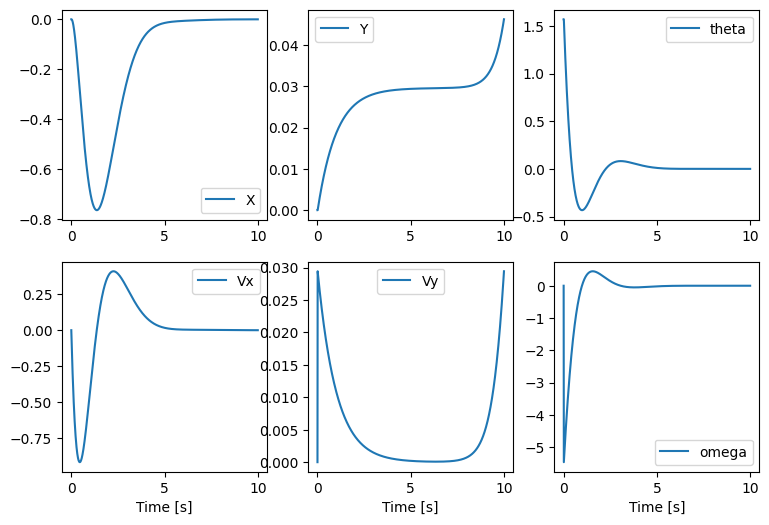

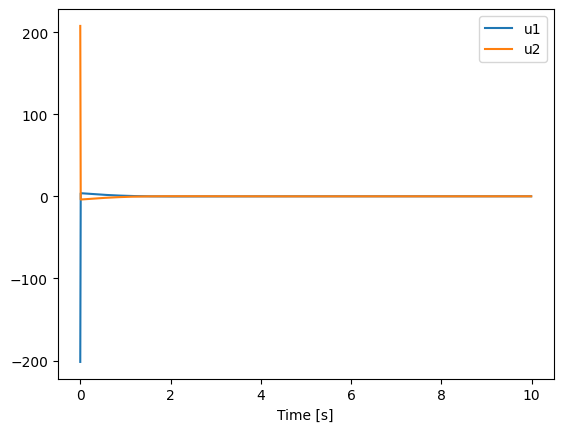

In [13]:
dynamics = LinearDynamics(jnp.array(As), jnp.array(Bs))

x0s = jnp.array([0., 0., 0., 0., np.pi/2, 0.])
# x0s = np.array([0., 0., 0., 0., 0, 0.])

u_nom = jnp.broadcast_to(jnp.array([quadrotor.MASS * quadrotor.GRAVITY / 2, quadrotor.MASS * quadrotor.GRAVITY / 2], ), (N, m))
x_nom = jnp.broadcast_to(jnp.array([0., 0., 0., 0., 0., 0.]), (N, n))

state, u = rollout_state_feedback_policy(
        dynamics,
        optimal_policy,
        x0s,
        np.arange(0, N),
        x_nom,
        u_nom,
        
    )
quadrotor.animate_robot(state.T,u.T)

state = state.T
u = u.T

t = np.arange(0, N/100 + dt, dt)
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

## Part 3 - following a trajectory using linearized dynamics

In [14]:
n = quadrotor.NUMBER_STATES
m = quadrotor.NUMBER_CONTROLS
n_ = quadrotor.NUMBER_STATES
u_0 = quadrotor.MASS * quadrotor.GRAVITY / 2
u_1 = quadrotor.MASS * quadrotor.GRAVITY / 2
theta = 0.
dt = quadrotor.DELTA_T # quadrotor.DELTA_T
r = quadrotor.LENGTH
I = quadrotor.INERTIA

N = 1000

Q_N = 1e+30  # Change to 100!

# Q state
# Qs = jnp.broadcast_to(jnp.eye(n)*Q_N, (N + 1, n, n)).copy()
Qs = jnp.broadcast_to(jnp.array([[1e+20, 0., 0., 0., 0., 0.],
                           [0., 1e+2, 0., 0., 0., 0.],
                           [0., 0., 1e+20, 0., 0., 0.],
                           [0., 0., 0., 1e+2, 0., 0.],
                           [0., 0., 0., 0., 1e+20, 0.],
                           [0., 0., 0., 0., 0., 1e+2]]), (N + 1, n, n)).copy()
# Qs[-1] *= Q_N

Rs = jnp.broadcast_to(jnp.eye(m)*(1e-10), (N, m, m))
Hs = jnp.broadcast_to(jnp.zeros((m, n)), (N, m, n)) # zeros

As = jnp.broadcast_to(jnp.array(
    [
    [1., dt, 0., 0., 0., 0.],
    [0., 1., 0., 0., (-(u_0 + u_1) * dt * jnp.cos(theta)) / m, 0.],
    [0., 0., 1., dt, 0., 0.],
    [0., 0., 0., 1., (-(u_0 + u_1) * dt * jnp.sin(theta)) / m, 0.],
    [0., 0., 0., 0., 1., dt],
    [0., 0., 0., 0., 0., 1.]
    ]), (N, n_, n))     

Bs = jnp.broadcast_to(jnp.array(
    [
    [0., 0.],
    [-(dt * jnp.sin(theta)) / m, -(dt * jnp.sin(theta)) / m],
    [0., 0.],
    [(dt * jnp.cos(theta)) / m, (dt * jnp.cos(theta)) / m],
    [0., 0.],
    [r * dt / I, -r * dt / I]
    ]), (N, n_, m))    

value_functions, optimal_policy = linear_quadratic_regulator(Qs, Rs, Hs, As, Bs)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAXgFtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MiBjMjRlMDZjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EltliIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwAAAwAAAwAKklieIofxeM38AAAD
AAC3gBewDCAKqAwqPoh2d2dPMAiJHr46cNtWROOk97EYcuOhdjfSGRcSFIT2QQogk1usCkIjgbve
KEdmLhPUrWKiDlZzSnqksdOELAKadiFKpilhtOjafm1mOX1J6uxzeubFMJTVobl6NaV/ZmIE+0nq
+5kR/oUJY96SuN/eI7GD2dh4ALf/96RonpS6nykSdfvgC0XmaI8JeYZinVWAiUyFuUoTV/lcuXFv
UdRea4b58SAMIAk2CCtJYygVVLw4WloMMy9I7rimbOHq8cOgq1+ZwDiLXa5SyHuvA1l78Ejst1tp
oKYWVoobqndaVlkE6AtzpeHooaoGT4NdMi/OacZ1oT+9hVmulCoTm1aUfXAvOmwJVeFoyHDIqUgd
hcLMjnuE3UZeTkAmzvyQvcvS4V3pz9EV9s4W/+S4UoeP6SozgOTM/s8GAALoAAAMCf65ejyPknRO
8qJAzicsMP5cCD014Ppbxxx7aX8VHrYhVMlpmalle1Y/c/cE/wC3LWS/fxx66dhK0XID/TkvyE+e
ly3wbAJaXNO1sK9NF4QcnPVrmC2lMAE0/L7+0K68xHpaAm9Kw2frV7Mc6MY3CpuN6IfRhIN1AwrO
eibMPA70a6/y9fQDGedSSwqodugnmDmgijzvsxaXgGtXRGUrDQgXBdj+4LX82tWaz5ghGQBtPbQZ
5VBg96frMYBV/YoLK6+L+ju8Hjqc/FKb+oyB4yMz+VqiGSA0zRIFoUJevM24L7eydq2v28GaTOqW
iUK06kReiKM1E9/axfRKDwC5mSoAc3+TrQxM1efVKtrsnat03AKfqX/lryN4QHC7N5O7IMwXK1EO
P56L/BivJTTR01AngpGmcV+Im5cnwvI5TzfaD1LCJj+uKbwAAAMAAAMAAAMAAAlRyFPrzmm1i8VI
nm9E8GdKFxqhWVu/V++cB0nJD3+HhjYw1O3F0pBOt8X2WwQUurjeRxZSFIycqkDjhHAc8RLhDjVD
1PQRfDSG7ymNaO1uEuCkbk77DSqktjYgf5P2wFOr/Uz+LSbx6el0bGH/OnCN3oRVc0spfxoKmrdf
mY21n9P9d7r4Sn832nq4fjwmtp43H4qyugzEbdTaN+W2JNeeudRYXAayjEWwaPQmq7m8c6UMjwJs
3aGR3ALm+CrShdT5EyKbw2ErxZB1tHO+1/8hqthoH2mJIBqiCSA2/c3qX/0f+WFrQnzx4ZXMu8UY
/6kdM/z2vNkUquAPk8XIbIUBKF97ZANsN7aGYwAx5/o/ZwX4ztpwxXBUs7G+fYO5M6dIwI40W9AH
ywv7VAAADwG3+EAAe0Vi5IANJidjgBUzHIiPX1ZMOUXIW3DenJ6QoPjHwkEFEMxGLjMPeMsBQaLH
k0oVQ8TeIk3P/8JwmzpOb8uwdVLuxnhiXNdwtZywzJpuVU7MFBdOItf1s5Wv3MadGmhBqDxkINwd
qd6WKIqpuYYOiUZQt/+GaHftiuowiY2waS2KZBbJN6IPGA+CheL/DJvd1NLOEP0ovSOlk6W86GMn
9gCxb08z+rBpdUoD6rfYDMbrUHDv4z1JXoPHc/wqGHRQfyIRRJnZQHPe5lV6F+XV1bG4gkZpKmGk
vPSfJZRJW6S1pj7YLJHl+K+9t2WPvKXQImZnfHrr2s6A1wcpieLdnKOtkEgbiMjj66Uhy9TL36Qr
mynk4a2+OsxUgfOQLN70OukkMMxtoP60jTpocytZsQQ7bSxTnEVYzKmKvE+7+L3/HdAQorvNsEBu
iGkOdGuPIbO2S+wLIPwDbMxEE75Mnov6Uu9DC9IfSs1kqoF9ofckn9xgNh9r1dAAACxBviQAAF7L
OJ4AMn5HUb4nbZ9MZL54N33DpybLWVadDp8StltNADaAeUVQ+/0PPqa+WiJvrZ5iAcByFF7/ajZ8
JCsgK9683B8fDG3uxZJVtuVxwi5voSRO+Ln7mZK4QfoUZ3y8UzH9VwDsMPTXlqNUg7nbmdIZYA1z
1RphspQk4BKWtgi7liYcoivHJhsG12xOs4MhIKr3dIuVn66pPFYz9T3iFOAb2aw6xvg7gZQSlmjZ
cq4E0Uj07i/fM2pKV9NuL0fFFzyZhas0Gik4fZGSwoN42ZvAJQw78jlUZ1tyvn9H6B6ynNyWTYWm
mWBj79bmRyYVfirYqmc/AarRAIHbDro0FszUwq2W8v+HRmGAMy1aTmyq2CpXQyGI/OnsyIE8zRD/
/3NAksOcUrvPhQf0Wf+pfx9hWh2kM1tHj7m46ICG8FyS2OB0U8v+wJPQ55O7q+uKII4z5zK0BZ1Y
lV2V4zxdNoeGfi3bEf0ZcspN/3AFhuHVdiqlVviWKe26cPt9kgd2mMTDOJG2FTnjqncltPuH1tCL
/2JbM152Q2pjZ881BbyqLIwAxYqSZwodXHw//9J1TUL1KxsTMf0qYEzyVSKF4J4JJTgcH5vgxB3P
nXS9dDwa6rCQZ7PyXad8X4cchwJebG6ZAAXJvvtTaswqY42AnJ6a6RzheTQDsIYAexp2GswnWAYT
q2gdexBXuNskCrr5bE6ARqhpi2e+47qpMccWRs8Rt35WGfU+8DkXz2t4zJHw7voH4cc5LQ3ZpOt+
6/5Ia3RwWrd6hx+6s/m8/uxzkUkr9ce8ndeSdANRw62+NsBTFkCpAAODXBcdKoJyZAIBekXmbwT0
Wid0M1S8eCh5hokgkKQ6KeF0XOdqfbsjXju/yJP3uAAAF57CX3vH/qkzXksg8AAAAwAAiy0zieoG
+54GtvnNeW8pgEmhLWDYhqwm2FQolevSEJ2O1njqCnug6fC9i9+Bwd8qYZAaA01WCxteD+WJiLi3
1ca832y/CYuxGGQncQVim

Text(0.5, 0, 'Time [s]')

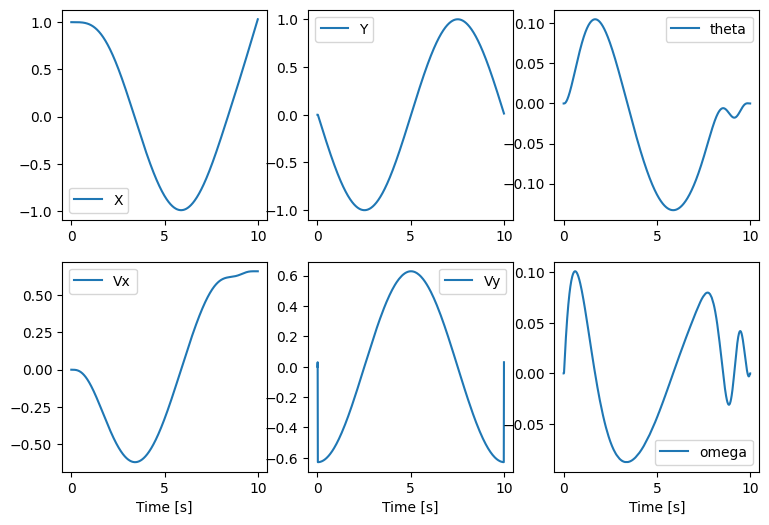

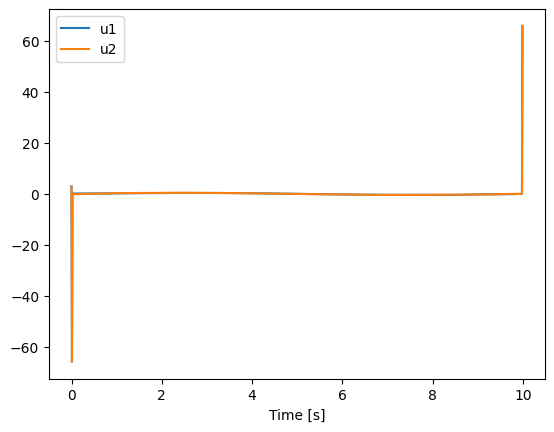

In [15]:

dynamics = LinearDynamics(jnp.array(As), jnp.array(Bs))

x0s = jnp.array([1., 0., 0., 0., 0, 0.])

thetas = jnp.linspace(jnp.pi / 2, 5 * jnp.pi / 2, N + 1)
x_nom = jax.vmap(lambda x: jnp.array([jnp.sin(x),
                                            0.,
                                            jnp.cos(x),
                                            0.,
                                            0.,
                                            0.]))(thetas)



u_nom = jnp.broadcast_to(jnp.array([quadrotor.MASS * quadrotor.GRAVITY / 2, quadrotor.MASS * quadrotor.GRAVITY / 2], ), (N, m))
# x_nom = jnp.broadcast_to(jnp.array([0., 0., 0., 0., 0., 0.]), (N, n))

state, u = rollout_state_feedback_policy(
        dynamics,
        optimal_policy,
        x0s,
        np.arange(0, N),
        x_nom,
        u_nom,
        
    )
quadrotor.animate_robot(state.T,u.T)

state = state.T
u = u.T

t = np.arange(0, N/100 + dt, dt)
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

In [8]:
#Part 3 (LQR trajectory to move in a circle at pi/4)
#Making drone move in a circle at pi/4
horizon_length = 1000
import trajectoryGeneration
part3Solver = trajectoryGeneration.solver3(horizon_length = horizon_length)
z0 = np.array([1., 0., 0., 0., np.pi / 4, 0.])
t, state, u = quadrotor.simulate(z0, part3Solver.move_circular_tilted_controller, horizon_length, disturbance = False)

quadrotor.animate_robot(state,u)

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

TypeError: solver3.solve_LQR_trajectory() missing 1 required positional argument: 'iState'

## Part 4 - iterative LQR
Now we would like to do more complicated motions with the robot, like a flip. In this case, we do not have a prescribed trajectory but we would like to compute a locally optimal trajectory while we optimize the controller. We will use the *iterative LQR* algorithm to solve this problem.
### Task 1 - reaching a vertical orientation
In the first task, we want the robot to reach a vertical orientation $\theta = \frac{\pi}{2}$ at the location $x=3$ and $y=3$ at time $t=5$ starting from $z_0=0$. During the rest of the motion, the robot should try and stay close to the origin. It should also try to keep its control $u$ close to the control needed to keep the robot at rest. We want to make sure the robot reaches the origin $z=0$ at the end of the movement. 
1. Find a time-varying cost function that promotes such a behavior (use only quadratic/linear terms for simplicity). Assume $T=10$ seconds.
2. Write a function ```compute_cost(z,u, horizon_length)``` that returns the cost of a trajectory z with control trajectory u (using the cost function you wrote in question 1).
3. Compute the quadratic approximation of your cost function along an arbitrary trajectory of states $z_n$ with control trajectory $u_n$ (this is not just your cost function!)
4. Write a function ```get_quadratic_approximation_cost(z, u, horizon_length)``` that returns the quadratic approximation (Hessian matrices and Jacobians) of the cost function when approximated along the trajectory z with control trajectory u.
5. Write the iLQR algorithm that solves the problem using the functions written above. DO NOT FORGET the line search step at each iteration. For the line search, start with $\alpha = 1.$ and decrease it by half when the cost does not improve (you can stop when $\alpha < 0.01$).
6. Test the algorithm using as initial guess $u$ such that the robot is at rest (using the results of Part 1.2). Analyze your results (probably you will need to "tune" your cost function), plot the initial and final state and control trajectories, show the animation. Use the simulation without perturbations for simplicity. 
7. What benefits and issues do you see with this approach?

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAfgxtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MiBjMjRlMDZjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
Er5liIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwAAAwAAAwAKklieIofxeM38AAAD
AAC3gBewDCAKqAwqPoh2d2dPMAiJHr46cNtWROOk97EYcuOhdjfSGRcSFIT2QQogk1usCkIjgbve
KEdmLhPUrWKiDlZzSnqksdOELAKadiFKpilhtOjafm1mOX1J6uxzeubFMJTVobl6NaV/ZmIE+0nq
+5kR/oUJY96SuN/eI7GD2dh4ALf/96RonpS6nykSdfvgC0XmaI8JeYZinVWAiUyFuUoTV/lcuXFv
UdRea4b58SAMIAk2CCtJYygVVLw4WloMMy9I7rimbOHq8cOgq1+ZwDiLXa5SyHuvA1l78Ejst1tp
oKYWVoobqndaVlkE6AtzpeHooaoGT4NdMi/OacZ1oT+9hVmulCoTm1aUfXAvOmwJVeFoyHDIqUgd
hcLMjnuE3UZeTkAmzvyQvcvS4V4TwI6J0M4V3jLOSh7/uXaHrAQo7Pu4WAAF0AAAGBP9cvR5HyTo
neVEgZxOWGH8uBB6a8H0t4449tL+Kj1sQqmS0zNSyvasfufuCf4BblrJfv449dOwlaLkB/pyX5Cf
PS5b4NgEtLmna2Femi8IOTnq1zBbSmACafl9/aFdeYj0tATelYbP1q9mOdGMbhU3G9EPowkG6gYV
nPRNmHgd6Ndf5evoBjU20uEbkO3QUVPuF4PLZP8nnqy0KIuiVhoQLgux/cFr+bWrNZ8wQjIA2nto
M8qgwe9P1mMAq/sUFldfF/R3eDx1OfilN/UZA8ZGZ/K1RDJAaZokC0KEvXmbcF9vZO1bX7eDNJnV
LVGDgEflk8TbjPf2sX0Sg8Aui7KOr+2SyYDTGe+U6rY1BDudAbL74edZoy/ryN5kt8iymceQZguV
qIcfz7v+DFeSmmipttXMaRs4sCVTG4HceRynmjPBEUkSR99iiQAAAwAAAwAAAwAABTorZZQCtNrF
4n4UAjp4M6ULjVCsrd8do84DpOSHv8PDGxhp5uLpSCdb46p2sQmNXG8jiykKNs5VIHHCOA54iXCH
Grmih6C+GkN3lMa0drcJcFI3WssFydnqVg+Vl1LJ1QIQUAOowFq6Kc88vv9z7ve1Qb4UBg6torKk
1rpmNtZ/T/Xe6+Ez+EjZHG90CyaEPZ7cVZXQZiNuptG93TEmvPNuisLgNZSWC1YVoTVd7eOdKGR4
E2btWF6qv3qENxSIo0iZFN4bCV4sg09Z1np+JTLGGMjd+iSAaogkgNq3Dqg/+BV+wa5J88frVKTF
qMf9SOmf57XmoKVXAHyeLjQYiwNOAu2QDbBzy6MBARUf5V2eFXoaFOMXBP+tjfPsHcmdVXsBA/qC
gGUSyBIAAN27uWYP++KoQCJEyEkgAfJLJEIAN+UwdoCChGREevryQcouQtuG9OT0hQcT5NIIKIZi
MXGYb5pYCg0WPJpQqh8aDeD1GO2TymzpOb8uwdVLuxnBiXNdwtZywzJpuZapes2MI34Hil8Wv3Ma
dG8RBqMxkINwdqd6WKIqDjCYhxsajHH/LNDv2xXUYRMbYMubZsgtkm9EHjAfBQvGPhk3u6mlnCH6
UZrsYab3zs2frewBYt6vbb5/3rwFX9vTkt0QJqDh38Z6wAAwn6/pLsDooWZEIokzsoDnvcyoFywy
dsk2CMEZpKmSkvPSfJZRJW6S3V4fYLJGKdPSbbssfcW/HHfFnAuccafB9cxDBNMa7GUdbIJI3EZH
H10pDl6mWf1/J9eCcw1t8Y5e+tyK7L5kWB8wlNr+b+v8kIxO83x1ioMVviWKcsC2GZUxV4n3fxe/
47oCFHd5tggN0Q0hzo1Y7RBjpDdooLTFzroNUe23FUb++JSTSqzR+bDqjvhmUlh0Ny1WLvlCQykQ
ABVLz1Zs78zgAAFJr6qe1o2RYzQGn5DoyTK93kOE4G1HcVI3hkAQd64Iy5i/FkKOF7PxQlF9oHyd
XxPXK10gl7V8jm+8Dha8wb8ja02Oe3ubIs15KTxR/TP0QVkTA6CRF9Z7vpTN+x/zirwXf8bhfkEi
enkKQvIvcZk9u/6PpfJDTEzTCQnILrXHumIfm0sEbz/r7zF+Q6zy96LwJMpmRhuG9OOcL+ROPmsi
vOokIvf4TYYXflGMIyYdaGTDiZ4n0ZfxoqszYGRS3bB7/J5E0AktiJkJ3lJo+OwQAByt95Bs+AWh
5VNUf8u18U3Zf4jYWjFUp2s6U9YRnIGMqiqA+YAc71GDUJq9TXkAzAYKaaXP7mcc4N6iGaXg67Ge
6Bilnxn6FI1HvE5vjcPZhtVqrdkKPV6zngSYjYSx9TBjJohPnesyNrcEr5VXRey2CsT21N1ixzXS
v7RQoujdU9u++knViY69CMz8RD07jK6J1pEcYrmxU+NeSlAe+v6SAQ/SYJ5Uxhqf7pedPf+2IlOq
a+MaIvk0S1WF8DlFy40zi44eSAKZoAv/pL0Cby6mkMdltYuKd8HbzUdoMxUnxQ3i/yk9vCIxdkYP
LHVdEgqIx0MnS1pdZ85wUVUIl4/Gdd4FQHNsCLhvp5FE7o5n6AVGWzkCMSHRsF0bneycCXP20ghM
eTZbDYfDmtEbhWJ+iv8z0qS4EjX+KTZCApN/4If/GfbJTaVT66kAABEMdHcTt0cohCg8iyQ/H/Qz
Bs/+4l4ybg6QAEfugTPxsBfuoEq1srJGQedfCYaJ5Qjj+cocOKdfJjgcfY5Gd9ol7ZIdkESGRrJH
jdgSicj6u+NYKvdf9QecGU5LM9MuQXabJC2hvNIAvGh32EgJlzjs26YAy0cIUsC70U1tl+BHNMKf
zoB7PNNlcfgdDWL7B+oyh8WBESTaDEPSoZ+afHKI0M+4qdjE1uAAABI9DftvQDuS3M1AAAADAAA/
Ts5NMz9Meiw1zKVfdv6+3

Text(0.5, 0, 'Time [s]')

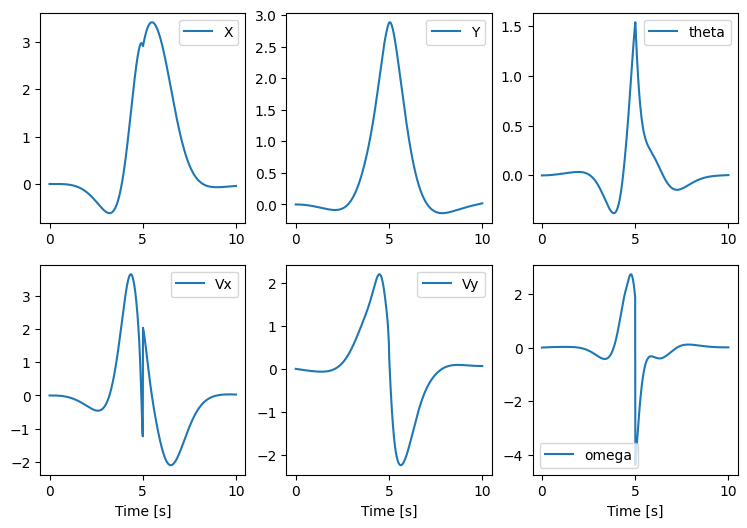

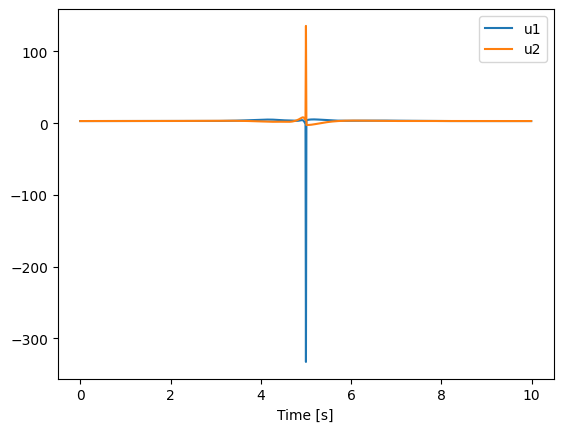

In [ ]:
#Part 4.1 (iLQR vertical orientation)
#Making drone reach vertical orientation come back to origin
horizon_length = 1000
import iLQR
part4Solver1 = iLQR.solver4(horizon_length = horizon_length)
z0 = np.array([0., 0., 0., 0., 0., 0.])
t, state, u = quadrotor.simulate(z0, part4Solver1.vertical_orientation_controller, horizon_length, disturbance = False)

quadrotor.animate_robot(state,u)

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

### Task 2 - doing a full flip
In the second task, we want the robot to do a full flip, trying to reach the upside-down state $x=1.5$, $y=3$ and $\theta = \pi$ at $t=5$ and upright state $x=3$, $y=0$ and $\theta = 2\pi$ at $T=10$.
8. Use iLQR (and a new cost function) to get the quadrotor to perform the task. Analyze your results. 
9. What benefits and issues do you see with this approach? Could you run the resulting controller on a real robot?

In [ ]:
#Part 4.2 (iLQR full flip)
#Making drone flip fully
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import quadrotor
horizon_length = 1000
import flip
part4Solver = flip.quadSys()
z0 = np.array([0., 0., 0., 0., 0., 0.])
part4Solver.ilrq()
t, state, u = quadrotor.simulate(z0, part4Solver.full_flip_controller, 1000 - 1, disturbance = False)

quadrotor.animate_robot(state,u)

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')